# Python: Conditional Average Treatment Effects (CATEs) for PLR models

In this simple example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate conditional average treatment effects with B-splines for one or two-dimensional effects in the [DoubleMLPLR](https://docs.doubleml.org/stable/guide/models.html#partially-linear-regression-model-plr) model.

In [1]:
import numpy as np
import pandas as pd
import doubleml as dml

from doubleml.datasets import make_heterogeneous_data

## Data

We define a data generating process to create synthetic data to compare the estimates to the true effect. The data generating process is based on the Monte Carlo simulation from [Oprescu et al. (2019)](http://proceedings.mlr.press/v97/oprescu19a.html).

The documentation of the data generating process can be found [here](https://docs.doubleml.org/dev/api/api.html#dataset-generators).

## One-dimensional Example

We start with an one-dimensional effect and create our training data. In this example the true effect depends only the first covariate $X_1$ and takes the following form

$$
g(X) = \exp(2X_0) + 3\sin(4X_0).
$$

The generated data also contain a callable with key `treatment_effect` to calculate the true treatment effect.

In [2]:
data_dict = make_heterogeneous_data(
    n_obs=2000,
    p=10,
    support_size=5,
    n_x=1,
)
treatment_effect = data_dict['treatment_effect']
data = data_dict['data']
data.head()

,y,d,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9
0,6.388910,0.894156,0.923861,0.942979,0.698173,0.982817,0.558143,0.371790,0.312999,0.445203,0.348491,0.366368
1,8.862733,1.432176,0.318602,0.542264,0.677010,0.303707,0.917365,0.867101,0.589458,0.437001,0.921115,0.741587
2,2.330586,1.547079,0.008878,0.992490,0.172806,0.475494,0.917217,0.080214,0.807006,0.604553,0.270278,0.307769
3,0.080800,-0.036521,0.260163,0.552492,0.394598,0.267206,0.669536,0.754943,0.189831,0.363862,0.069750,0.933854
4,3.788874,0.544138,0.367560,0.076433,0.553376,0.425910,0.965611,0.996970,0.949449,0.610039,0.686292,0.354205


First, define the ``DoubleMLData`` object.

In [3]:
data_dml_base = dml.DoubleMLData(
    data,
    y_col='y',
    d_cols='d'
)

Next, define the learners for the nuisance functions and fit the [PLR Model](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLPLR.html). Remark that the learners are not optimal for the linear form of this example.

In [4]:
# First stage estimation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
ml_l = RandomForestRegressor(n_estimators=500)
ml_m = RandomForestRegressor(n_estimators=500)

np.random.seed(42)

dml_plr = dml.DoubleMLPLR(data_dml_base,
                          ml_l=ml_l,
                          ml_m=ml_m,
                          n_folds=5)
print("Training PLR Model")
dml_plr.fit()

print(dml_plr.summary)

Training PLR Model
       coef   std err           t  P>|t|    2.5 %    97.5 %
d  4.466909  0.042898  104.128446    0.0  4.38283  4.550988


To estimate the CATE, we rely on the best-linear-predictor of the linear score as in [Semenova et al. (2021)](https://doi.org/10.1093/ectj/utaa027) To approximate the target function $\theta_0(x)$ with a linear form, we have to define a data frame of basis functions. Here, we rely on [patsy](https://patsy.readthedocs.io/en/latest/) to construct a suitable basis of [B-splines](https://en.wikipedia.org/wiki/B-spline).

In [5]:
import patsy
design_matrix = patsy.dmatrix("bs(x, df=5, degree=2)", {"x": data["X_0"]})
spline_basis = pd.DataFrame(design_matrix)

To estimate the parameters to calculate the CATE estimate call the ``cate()`` method and supply the dataframe of basis elements.

In [6]:
cate = dml_plr.cate(spline_basis)
print(cate)

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
       coef   std err          t          P>|t|    [0.025    0.975]
0  1.022756  0.140868   7.260407   5.505685e-13  0.746493  1.299019
1  2.031614  0.234246   8.672999   8.564637e-18  1.572221  2.491006
2  4.427119  0.154276  28.696016  6.857928e-152  4.124559  4.729679
3  4.405064  0.179755  24.505923  3.774083e-116  4.052536  4.757591
4  3.225276  0.184243  17.505556   6.137683e-64  2.863947  3.586605
5  4.055048  0.197241  20.558872   2.445618e-85  3.668228  4.441868


To obtain the confidence intervals for the CATE, we have to call the ``confint()`` method and a supply a dataframe of basis elements.
This could be the same basis as for fitting the CATE model or a new basis to e.g. evaluate the CATE model on a grid.
Here, we will evaluate the CATE on a grid from 0.1 to 0.9 to plot the final results.
Further, we construct uniform confidence intervals by setting the option ``joint`` and providing a number of bootstrap repetitions ``n_rep_boot``.

In [7]:
new_data = {"x": np.linspace(0.1, 0.9, 100)}
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], new_data)[0])
df_cate = cate.confint(spline_grid, level=0.95, joint=True, n_rep_boot=2000)
print(df_cate)

       2.5 %    effect    97.5 %
0   2.208606  2.461443  2.714279
1   2.309987  2.567037  2.824087
2   2.408177  2.670958  2.933740
3   2.503913  2.773208  3.042503
4   2.597806  2.873785  3.149765
..       ...       ...       ...
95  4.359998  4.593011  4.826024
96  4.368733  4.597088  4.825444
97  4.380801  4.604497  4.828193
98  4.395560  4.615239  4.834918
99  4.412217  4.629312  4.846407

[100 rows x 3 columns]


Finally, we can plot our results and compare them with the true effect.

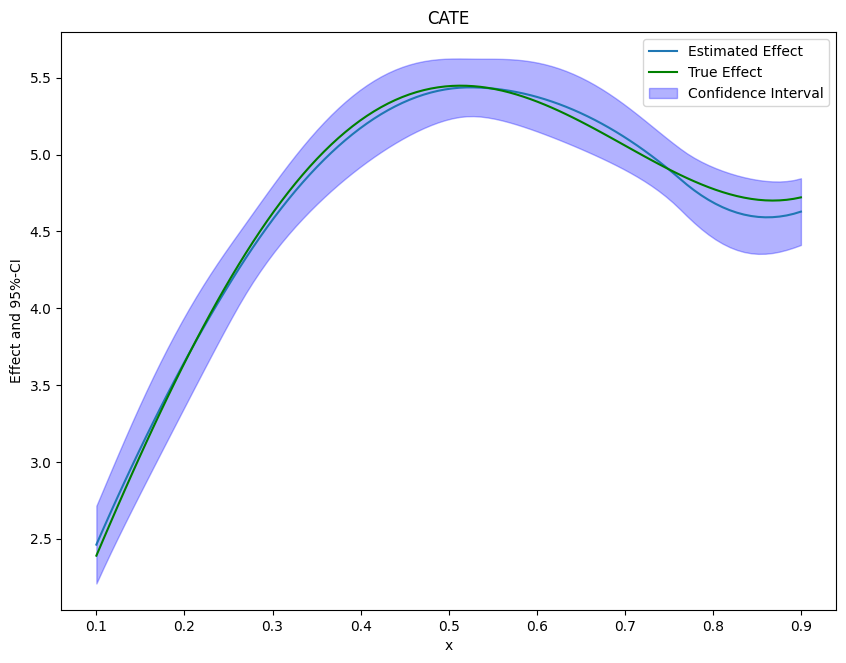

In [8]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5

df_cate['x'] = new_data['x']
df_cate['true_effect'] = treatment_effect(new_data["x"].reshape(-1, 1))
fig, ax = plt.subplots()
ax.plot(df_cate['x'],df_cate['effect'], label='Estimated Effect')
ax.plot(df_cate['x'],df_cate['true_effect'], color="green", label='True Effect')
ax.fill_between(df_cate['x'], df_cate['2.5 %'], df_cate['97.5 %'], color='b', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('CATE')
plt.xlabel('x')
_ =  plt.ylabel('Effect and 95%-CI')

If the effect is not one-dimensional, the estimate still corresponds to the projection of the true effect on the basis functions.

## Two-Dimensional Example

It is also possible to estimate multi-dimensional conditional effects. We will use a similar data generating process but now the effect depends on the first two covariates $X_0$ and $X_1$ and takes the following form
$$
g(X) = \exp(2X_0) + 3\sin(4X_1).
$$

With the argument ``n_x=2`` we can specify set the effect to be two-dimensional.

In [25]:
data_dict = make_heterogeneous_data(
    n_obs=5000,
    p=10,
    support_size=5,
    n_x=2,
)
treatment_effect = data_dict['treatment_effect']
data = data_dict['data']
data.head()

,y,d,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9
0,21.638574,1.975520,0.980899,0.451780,0.551806,0.434759,0.975962,0.725772,0.502699,0.760994,0.148696,0.033333
1,8.883402,2.041938,0.510152,0.693154,0.103934,0.263359,0.981590,0.176044,0.161202,0.377109,0.999251,0.309967
2,9.722389,2.247265,0.203547,0.177120,0.793819,0.835752,0.714689,0.882295,0.902689,0.792286,0.647785,0.771150
3,14.637273,1.694993,0.959335,0.715016,0.739818,0.341950,0.480429,0.961551,0.886890,0.149713,0.095202,0.454247
4,-0.122781,2.238182,0.176883,0.960606,0.753939,0.838952,0.656843,0.789640,0.226322,0.987177,0.591266,0.338614


As univariate example estimate the [PLR Model](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLPLR.html).

In [10]:
data_dml_base = dml.DoubleMLData(
    data,
    y_col='y',
    d_cols='d'
)

In [11]:
# First stage estimation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
ml_l = RandomForestRegressor(n_estimators=500)
ml_m = RandomForestRegressor(n_estimators=500)

np.random.seed(42)

dml_plr = dml.DoubleMLPLR(data_dml_base,
                          ml_l=ml_l,
                          ml_m=ml_m,
                          n_folds=5)
print("Training PLR Model")
dml_plr.fit()

print(dml_plr.summary)

Training PLR Model
       coef   std err          t  P>|t|     2.5 %    97.5 %
d  4.370179  0.052973  82.497779    0.0  4.266353  4.474004


As above, we will rely on the [patsy](https://patsy.readthedocs.io/en/latest/) package to construct the basis elements.
In the two-dimensional case, we will construct a tensor product of B-splines (for more information see [here](https://patsy.readthedocs.io/en/latest/spline-regression.html#tensor-product-smooths)).

In [12]:
design_matrix = patsy.dmatrix("te(bs(x_0, df=7, degree=3), bs(x_1, df=7, degree=3))", {"x_0": data["X_0"], "x_1": data["X_1"]})
spline_basis = pd.DataFrame(design_matrix)

cate = dml_plr.cate(spline_basis)
print(cate)

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
        coef   std err          t         P>|t|    [0.025     0.975]
0   2.499607  0.138232  18.082723  7.945380e-71  2.228611   2.770602
1  -2.778645  1.162123  -2.391008  1.683933e-02 -5.056921  -0.500369
2   2.108748  1.186407   1.777423  7.555999e-02 -0.217136   4.434632
3   3.277081  1.009500   3.246241  1.177186e-03  1.298013   5.256149
4   1.176052  0.976060   1.204897  2.283006e-01 -0.737459   3.089563
5  -3.463093  1.213726  -2.853274  4.345089e-03 -5.842535  -1.083652
6  -3.723075  1.363301  -2.730927  6.338024e-03 -6.395748  -1.050401
7  -7.371612  1.249751  -5.898465  3.912694e-09 -9.821678  -4.921546
8  -0.228794  1.171730  -0.195261  8.451963e-01 -2.525904   2.068317
9   1.675069  1.231926   1.359716  1.739817e-01 -0.740051   4.090190
10  1.034274  1.022341   1.011672  3.117442e-01 -0.969967   3.038515
11  1.527185  1.051226   1.452765  1.463523e-01 -0.533685   3.58

Finally, we create a new grid to evaluate and plot the effects.

In [13]:
grid_size = 100
x_0 = np.linspace(0.1, 0.9, grid_size)
x_1 = np.linspace(0.1, 0.9, grid_size)
x_0, x_1 = np.meshgrid(x_0, x_1)

new_data = {"x_0": x_0.ravel(), "x_1": x_1.ravel()}

In [14]:
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], new_data)[0])
df_cate = cate.confint(spline_grid, joint=True, n_rep_boot=2000)
print(df_cate)

         2.5 %    effect    97.5 %
0     1.105442  1.942230  2.779018
1     1.149221  1.964224  2.779228
2     1.203151  1.991980  2.780810
3     1.263703  2.024603  2.785504
4     1.327327  2.061198  2.795069
...        ...       ...       ...
9995  3.414696  4.569876  5.725055
9996  3.468284  4.702620  5.936957
9997  3.529070  4.833219  6.137369
9998  3.600051  4.960592  6.321134
9999  3.683284  5.083658  6.484031

[10000 rows x 3 columns]


In [26]:
import plotly.graph_objects as go

grid_array = np.array(list(zip(x_0.ravel(), x_1.ravel())))
true_effect = treatment_effect(grid_array).reshape(x_0.shape)
effect = np.asarray(df_cate['effect']).reshape(x_0.shape)
lower_bound = np.asarray(df_cate['2.5 %']).reshape(x_0.shape)
upper_bound = np.asarray(df_cate['97.5 %']).reshape(x_0.shape)

fig = go.Figure(data=[
    go.Surface(x=x_0,
               y=x_1,
               z=true_effect),
    go.Surface(x=x_0,
               y=x_1,
               z=upper_bound, showscale=False, opacity=0.4,colorscale='purp'),
    go.Surface(x=x_0,
               y=x_1,
               z=lower_bound, showscale=False, opacity=0.4,colorscale='purp'),
])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))

fig.update_layout(scene = dict(
                    xaxis_title='X_0',
                    yaxis_title='X_1',
                    zaxis_title='Effect'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()